In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [3]:

!unzip /content/dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/train/Pepper Green/Pepper Green_264.jpg  
  inflating: train/train/Pepper Green/Pepper Green_265.jpg  
  inflating: train/train/Pepper Green/Pepper Green_266.jpg  
  inflating: train/train/Pepper Green/Pepper Green_267.jpg  
  inflating: train/train/Pepper Green/Pepper Green_268.jpg  
  inflating: train/train/Pepper Green/Pepper Green_269.jpg  
  inflating: train/train/Pepper Green/Pepper Green_27.jpg  
  inflating: train/train/Pepper Green/Pepper Green_270.jpg  
  inflating: train/train/Pepper Green/Pepper Green_271.jpg  
  inflating: train/train/Pepper Green/Pepper Green_272.jpg  
  inflating: train/train/Pepper Green/Pepper Green_273.jpg  
  inflating: train/train/Pepper Green/Pepper Green_274.jpg  
  inflating: train/train/Pepper Green/Pepper Green_275.jpg  
  inflating: train/train/Pepper Green/Pepper Green_276.jpg  
  inflating: train/train/Pepper Green/Pepper Green_277.jpg  
  inflating: train/train/Pepper Gre

In [4]:
train_path = '/content/train/train'

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed = 99,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16854 files belonging to 33 classes.


In [6]:
class_names = dataset.class_names
class_names

['Apple Braeburn',
 'Apple Granny Smith',
 'Apricot',
 'Avocado',
 'Banana',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe',
 'Cherry',
 'Clementine',
 'Corn',
 'Cucumber Ripe',
 'Grape Blue',
 'Kiwi',
 'Lemon',
 'Limes',
 'Mango',
 'Onion White',
 'Orange',
 'Papaya',
 'Passion Fruit',
 'Peach',
 'Pear',
 'Pepper Green',
 'Pepper Red',
 'Pineapple',
 'Plum',
 'Pomegranate',
 'Potato Red',
 'Raspberry',
 'Strawberry',
 'Tomato',
 'Watermelon']

In [7]:
len(dataset)

527

In [8]:
527 * 32
# Total Image we have is 16854, and we have a set of (batch) 32.
# So if we multiply the length of dataset by batch size will get all images.

16864

In [9]:
for image_batch, labels_batch in dataset.take(1): # take first batch.
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[18  7 32 12 17  4 22 22 16 24  1 14 11 25 24  5  9 18 13 17 14  5 15 12
 18  9 13  1 13  9 28 15]


In [10]:
for image_batch, labels_batch in dataset.take(1): # take first batch.
#     print(image_batch[0])
    print(image_batch[0].numpy())


[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]


# Visualize

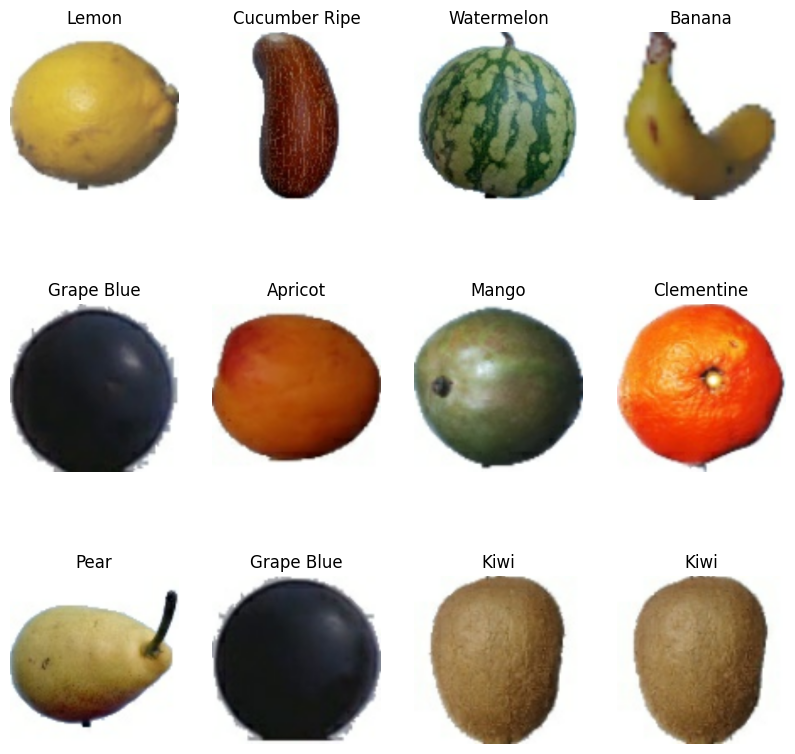

In [11]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1): # take first batch.
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
plt.savefig("Visualization.pdf", dpi=300, format="pdf")

In [12]:
def get_dataset(ds, train_split=0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):
    assert(train_split + test_split + val_split) == 1

    ds_size = len(ds)
    if shuffle:
        df = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
#     test_size = int(test_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset(dataset)

In [14]:
len(train_ds), len(val_ds), len(test_ds)

(421, 52, 54)

In [15]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
# apply data augmentation on training data
train_ds = train_ds.map(
    lambda x, y : (data_augmentation(x, training = True), y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

# Model

In [18]:
CHANNELS = 3

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

In [20]:
model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [21]:
model.build(input_shape = input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# COmpile

In [23]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [24]:
hist = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,    verbose = 1,
    epochs = 5,

)

Epoch 1/5
421/421 [==============================] - 160s 360ms/step - loss: 1.5637 - accuracy: 0.5048 - val_loss: 0.5329 - val_accuracy: 0.8215
Epoch 2/5
421/421 [==============================] - 142s 336ms/step - loss: 0.3858 - accuracy: 0.8697 - val_loss: 0.2601 - val_accuracy: 0.9153
Epoch 3/5
421/421 [==============================] - 150s 356ms/step - loss: 0.1889 - accuracy: 0.9351 - val_loss: 0.1481 - val_accuracy: 0.9543
Epoch 4/5
421/421 [==============================] - 144s 343ms/step - loss: 0.1267 - accuracy: 0.9582 - val_loss: 0.0398 - val_accuracy: 0.9850
Epoch 5/5
421/421 [==============================] - 141s 334ms/step - loss: 0.0875 - accuracy: 0.9701 - val_loss: 0.0763 - val_accuracy: 0.9730


In [25]:
scores = model.evaluate(test_ds)
scores

54/54 [==============================] - 15s 57ms/step - loss: 0.0781 - accuracy: 0.9709


[0.07807556539773941, 0.9708963632583618]

# Referring to History

In [26]:
hist

In [27]:
hist.params

{'verbose': 1, 'epochs': 5, 'steps': 421}

In [28]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
type(hist.history['loss'])

list

In [30]:
len(hist.history['loss'])

5

In [31]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

In [32]:
EPOCHS = 5

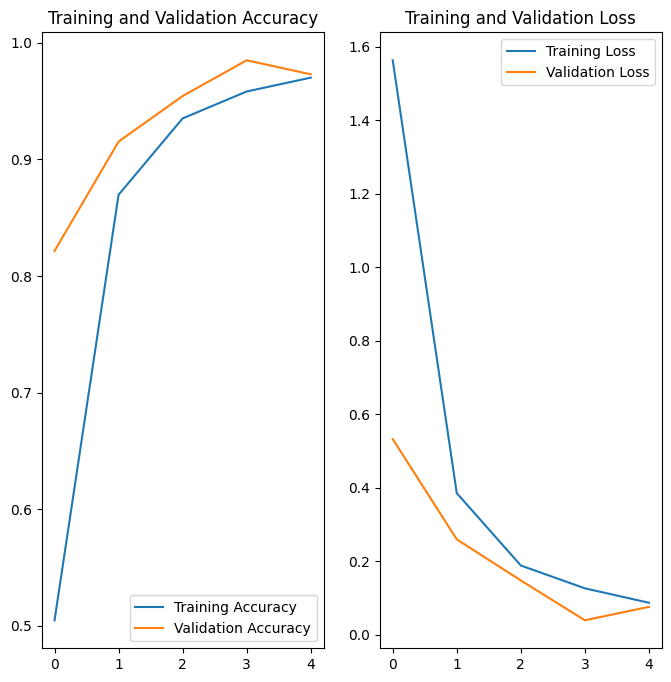

In [33]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.savefig("training and validation loss.pdf", dpi=300, format="pdf")


# Run Prediction on a Sample Image

In [34]:
import numpy as np

First Image to Predict
Actual Label :  Grape Blue
1/1 [==============================] - 0s 144ms/step
Predicted Label :  Grape Blue


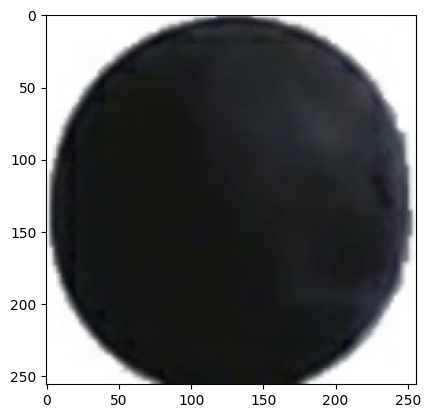

In [35]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First Image to Predict")
    plt.imshow(first_image)
    print("Actual Label : ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label : ", class_names[np.argmax(batch_prediction[0])])

# Making Prediciton dynamic

In [36]:
def funcPredict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    pred = model.predict(img_array)

    pred_class = class_names[np.argmax(pred[0])]
    confidence = round(100 * (np.max(pred[0])), 2)

    return pred_class, confidence

1/1 [==============================] - 0s 25ms/step


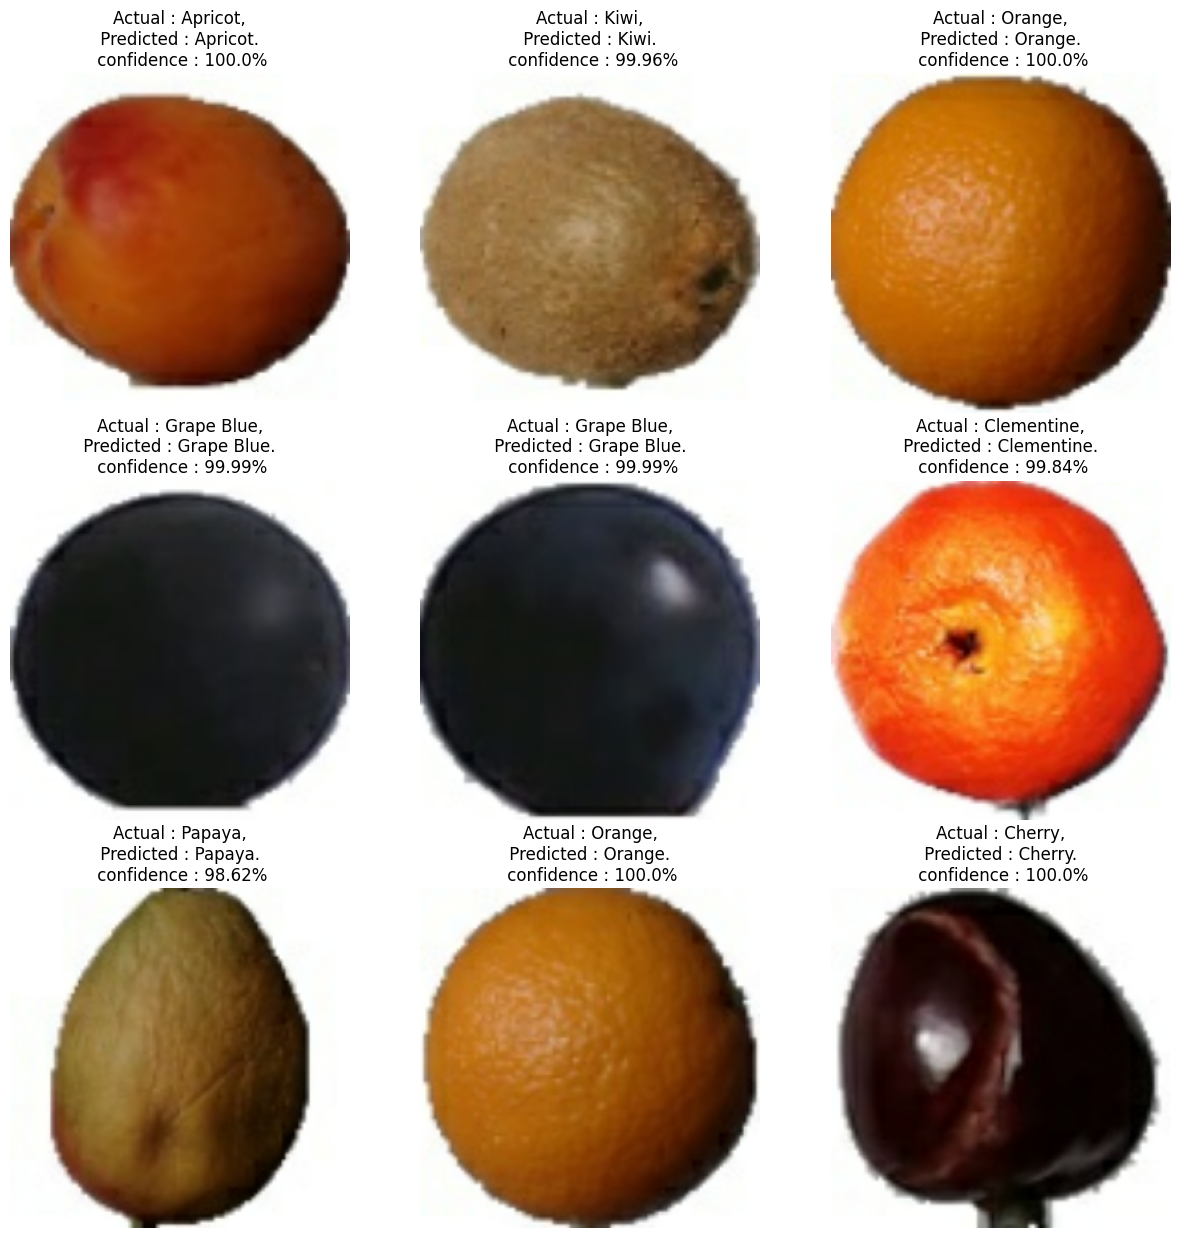

In [42]:
plt.figure(figsize = (15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = funcPredict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual : {actual_class},\n Predicted : {predicted_class}. \n confidence : {confidence}%")
        plt.axis("off")
plt.savefig("confidence.pdf", dpi=300, format="pdf")

# Saving the Model

In [38]:
# import os
# model_version = max([int(i) for i in os.listdir("models") + [0]])+1
# model.save(f"models/model")

In [39]:
model.save("models/fruits.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 26ms/step
Precision: 0.9733617021446965
Recall: 0.9714784633294529
Accuracy: 0.9714784633294529
Confusion Matrix:


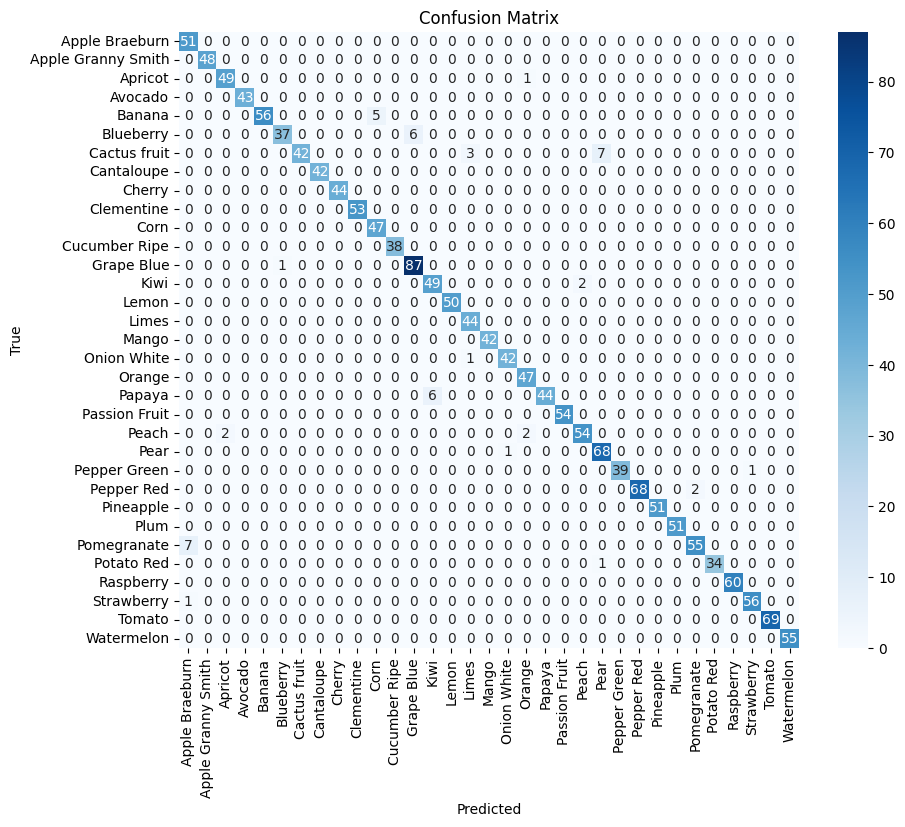

<Figure size 640x480 with 0 Axes>

In [43]:
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Assuming 'test_ds' is the test dataset
y_true = []
y_pred = []

# Iterate through the test dataset to collect true and predicted labels
for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    predictions = model.predict(images_batch)
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate precision, recall, accuracy, and confusion matrix
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig("confusionmatrix.pdf", dpi=300, format="pdf")


#DENSE NET MODEL

In [45]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D

# ... (Existing code)

# Define a function to create the DenseNet model
def build_densenet(input_shape, num_classes):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create and compile the DenseNet model
densenet_model = build_densenet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), num_classes=n_classes)
densenet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the DenseNet model
hist_densenet = densenet_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5
)

# Evaluate the DenseNet model on the test set
scores_densenet = densenet_model.evaluate(test_ds)
scores_densenet_acc = scores_densenet[1]

print(f"DenseNet Model - Test Accuracy: {scores_densenet_acc}")



Epoch 1/5
421/421 [==============================] - 202s 452ms/step - loss: 0.5671 - accuracy: 0.8582 - val_loss: 0.2500 - val_accuracy: 0.9441
Epoch 2/5
421/421 [==============================] - 184s 437ms/step - loss: 0.0996 - accuracy: 0.9730 - val_loss: 0.0479 - val_accuracy: 0.9886
Epoch 3/5
421/421 [==============================] - 186s 440ms/step - loss: 0.0465 - accuracy: 0.9875 - val_loss: 0.0565 - val_accuracy: 0.9856
Epoch 4/5
421/421 [==============================] - 183s 435ms/step - loss: 0.0427 - accuracy: 0.9869 - val_loss: 0.1087 - val_accuracy: 0.9681
Epoch 5/5
54/54 [==============================] - 28s 294ms/step - loss: 0.0179 - accuracy: 0.9971
DenseNet Model - Test Accuracy: 0.9970896244049072


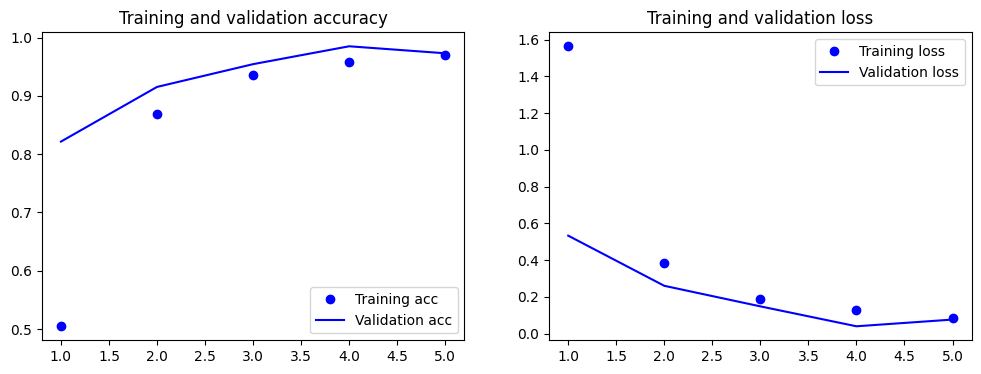

54/54 [==============================] - 14s 33ms/step - loss: 0.0754 - accuracy: 0.9715
Test Loss: 0.075428307056427, Test Accuracy: 0.9714784622192383
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

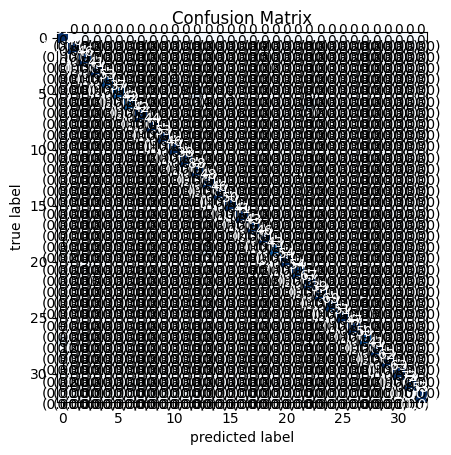

                    precision    recall  f1-score   support

    Apple Braeburn       0.85      1.00      0.92        51
Apple Granny Smith       1.00      1.00      1.00        48
           Apricot       0.96      0.98      0.97        47
           Avocado       1.00      1.00      1.00        41
            Banana       1.00      0.91      0.95        58
         Blueberry       0.97      0.86      0.91        43
      Cactus fruit       1.00      0.82      0.90        51
        Cantaloupe       1.00      1.00      1.00        42
            Cherry       1.00      1.00      1.00        44
        Clementine       1.00      1.00      1.00        53
              Corn       0.90      1.00      0.95        46
     Cucumber Ripe       1.00      1.00      1.00        38
        Grape Blue       0.94      0.99      0.96        89
              Kiwi       0.86      0.98      0.91        49
             Lemon       1.00      1.00      1.00        46
             Limes       0.93      1.00

In [48]:
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix


# Define a function to plot accuracy and loss
def plot_accuracy_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    plt.savefig("densenet training and validation loss.pdf", dpi=300, format="pdf")


# Plot accuracy and loss
plot_accuracy_loss(hist)

# Evaluate the model on the test set
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]}, Test Accuracy: {scores[1]}")

# Get predictions for the test set
y_true = []
y_pred = []

for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    y_pred.extend(np.argmax(model.predict(images_batch), axis=1))

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_mat=conf_matrix, show_normed=True)
plt.title('Confusion Matrix')
plt.show()

# Generate and print classification report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print(class_report)
